In [ ]:
"""
*******************************************************************************

Project: RL, assignment 2
File: warehouse_robot_dqn_image.ipynb
Author: Hamid Manouchehri
Email: hmanouch@buffalo.edu
Date: Apr 2, 2025

Description:

License:
This script is licensed under the MIT License.
You may obtain a copy of the License at
    https://opensource.org/licenses/MIT

SPDX-License-Identifier: MIT

Disclaimer:
This software is provided "as is", without warranty of any kind, express or
implied, including but not limited to the warranties of merchantability,
fitness for a particular purpose, and noninfringement. In no event shall the
authors be liable for any claim, damages, or other liability, whether in an
action of contract, tort, or otherwise, arising from, out of, or in connection
with the software or the use or other dealings in the software.

*******************************************************************************
"""

'\n*******************************************************************************\n\nProject: RL, assignment 2\nFile: warehouse_robot_dqn_image.ipynb\nAuthor: Hamid Manouchehri\nEmail: hmanouch@buffalo.edu\nDate: Apr 2, 2025\n\nDescription:\n\nLicense:\nThis script is licensed under the MIT License.\nYou may obtain a copy of the License at\n    https://opensource.org/licenses/MIT\n\nSPDX-License-Identifier: MIT\n\nDisclaimer:\nThis software is provided "as is", without warranty of any kind, express or\nimplied, including but not limited to the warranties of merchantability,\nfitness for a particular purpose, and noninfringement. In no event shall the\nauthors be liable for any claim, damages, or other liability, whether in an\naction of contract, tort, or otherwise, arising from, out of, or in connection\nwith the software or the use or other dealings in the software.\n\n*******************************************************************************\n'

In [1]:
#!/usr/bin/env python3

import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
import matplotlib.colors as mcolors
from IPython.display import clear_output
# from environment import WumpusWorldEnvironment
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from collections import deque
import random
import torch.optim as optim
import os

/home/hamid/miniconda3/envs/rl_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
################################
## Custom Function Definition ##
################################
def save_plot_as_img(png_plot_name, dir):
    """ Call this function after plt.plot(...)"""
    
    save_path = os.path.join(dir, png_plot_name)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    print(f"Plot saved at: {save_path}")

def change_to_gray_scale(rgb_img):

    gray_scale_img = 0.2989 * rgb_img[:, :, 0] + 0.5870 * rgb_img[:, :, 1] + 0.1140 * rgb_img[:, :, 2]

    return gray_scale_img

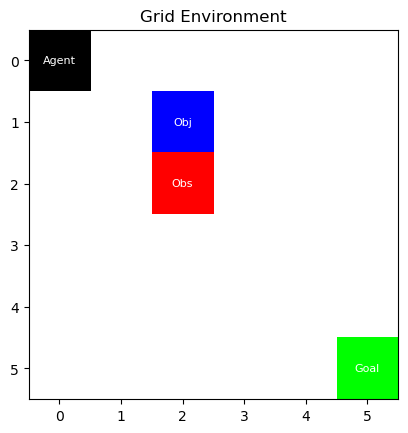

In [3]:
grid_size = 6
grid = np.ones((grid_size, grid_size, 3))
# Define grid size
grid_size = 6  # 6x6 grid

# Initialize grid with default background (White = 4)
grid = np.ones((grid_size, grid_size, 3), dtype=float)

# Define agent and goal positions
init_agent_pos = [0, 0]  # Start position
goal_pos = [5, 5]  # Goal position
object_pos = [1, 2]  # Goal position
obstacle_1_pos = [2, 2]  # Goal position


# Assign integer values to the grid
grid[tuple(init_agent_pos)] = [0., 0., 0.]    # Agent: black
grid[tuple(goal_pos)] = [0.0, 1.0, 0.0]            # Goal: green
grid[tuple(object_pos)] = [0.0, 0.0, 1.0]          # Object: blue
grid[tuple(obstacle_1_pos)] = [1.0, 0.0, 0.0]         # Obstacle: red


for i in range(6):  # rows
    for j in range(6):  # columns
        text = ""
        if [i, j] == init_agent_pos:
            text = "Agent"
        elif [i, j] == goal_pos:
            text = "Goal"
        elif [i, j] == object_pos:
            text = "Obj"
        elif [i, j] == obstacle_1_pos:
            text = "Obs"
        
        # Only annotate if there is text to display
        if text:
            plt.text(j, i, text, ha="center", va="center", color="white", fontsize=8)


# Display the grid with correct colors
# gray_img = change_to_gray_scale(grid)
# plt.imshow(gray_img, cmap='gray', vmin=0, vmax=1)
plt.imshow(grid)
plt.title("Grid Environment")
plt.show()


In [4]:


class GridEnvironment(gym.Env):
    metadata = {'render.modes': []}
    
    def __init__(self, max_timesteps):
        # Set grid size as a class attribute.
        self.grid_size = 6
        
        # We keep the observation as a vector: [carry_flag, x, y]
        self.observation_space = spaces.MultiDiscrete([2, self.grid_size, self.grid_size])
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = max_timesteps
        self.reward = 0
        
        self.timestep = 0
        self.agent_carry_obj = False
        self.agent_pos = [0, 0]
        self.goal_pos = [5, 5]
        self.object_pos = [1, 2]
        self.obstacle_1_pos = [2, 2]
        
        # Initialize state as an RGB image (values between 0 and 1)
        self.state = np.ones((self.grid_size, self.grid_size, 3), dtype=float)
        self.state[tuple(self.agent_pos)] = [0.0, 0.0, 0.0]   # Agent: black
        self.state[tuple(self.goal_pos)] = [0.0, 1.0, 0.0]     # Goal: green
        self.state[tuple(self.object_pos)] = [0.0, 0.0, 1.0]   # Object: blue
        self.state[tuple(self.obstacle_1_pos)] = [1.0, 0.0, 0.0] # Obstacle: red
    
    def reset(self, **kwargs):
        self.agent_carry_obj = False
        self.agent_pos = [0, 0]
        self.goal_pos = [5, 5]
        self.object_pos = [1, 2]
        self.obstacle_1_pos = [2, 2]
        self.reward = 0
        self.timestep = 0
        
        # Reset the state to a new RGB image.
        self.state = np.ones((self.grid_size, self.grid_size, 3), dtype=float)
        self.state[tuple(self.agent_pos)] = [0.0, 0.0, 0.0]   # Agent: black
        self.state[tuple(self.goal_pos)] = [0.0, 1.0, 0.0]     # Goal: green
        self.state[tuple(self.object_pos)] = [0.0, 0.0, 1.0]   # Object: blue
        self.state[tuple(self.obstacle_1_pos)] = [1.0, 0.0, 0.0] # Obstacle: red
        
        # Return observation as [carry_flag, x, y]
        # observation = np.array([int(self.agent_carry_obj)] + self.agent_pos)
        observation = change_to_gray_scale(self.state)
        info = {}
        return observation, info

    def pick_up_obj(self):
        # When picking up the object, change its cell color to white.
        self.state[tuple(self.object_pos)] = [1.0, 1.0, 1.0]
        self.agent_carry_obj = True

    def drop_off_obj(self):
        # When dropping off the object, change the goal cell to white.
        self.state[tuple(self.goal_pos)] = [1.0, 1.0, 1.0]
        self.agent_carry_obj = False

    def step(self, action):
        self.reward -= 1
        terminated = False

        # Compute potential new position based on action.
        new_agent_pos = self.agent_pos.copy()
        if action == 0:  # down
            new_agent_pos[0] += 1
        elif action == 1:  # up
            new_agent_pos[0] -= 1
        elif action == 2:  # right
            new_agent_pos[1] += 1
        elif action == 3:  # left
            new_agent_pos[1] -= 1
            
        # Ensure new position is within bounds.
        new_agent_pos = np.clip(new_agent_pos, 0, self.grid_size - 1).tolist()
        
        # Obstacle avoidance: if new position equals the obstacle, apply penalty and do not move.
        if np.array_equal(new_agent_pos, self.obstacle_1_pos):
            self.reward -= 25
        else:
            self.agent_pos = new_agent_pos
        
        # Update grid state.
        self.state = np.ones((self.grid_size, self.grid_size, 3), dtype=float)
        self.state[tuple(self.agent_pos)] = [0.0, 0.0, 0.0]   # Agent: black
        self.state[tuple(self.goal_pos)] = [0.0, 1.0, 0.0]     # Goal: green
        if not self.agent_carry_obj:
            self.state[tuple(self.object_pos)] = [0.0, 0.0, 1.0]   # Object: blue
        self.state[tuple(self.obstacle_1_pos)] = [1.0, 0.0, 0.0] # Obstacle: red
        
        # Create observation as [carry_flag, x, y]
        # observation = np.array([int(self.agent_carry_obj)] + self.agent_pos)
        observation = change_to_gray_scale(self.state)
        
        # Check for pickup.
        if np.array_equal(self.agent_pos, self.object_pos) and not self.agent_carry_obj:
            self.pick_up_obj()
            self.reward += 25
            # Change the object's cell color to black once picked up.
            self.state[tuple(self.object_pos)] = [0.0, 0.0, 0.0]
        
        # Check for dropoff.
        if np.array_equal(self.agent_pos, self.goal_pos) and self.agent_carry_obj:
            self.drop_off_obj()
            self.reward += 100
            terminated = True
            # Change the goal cell color to black after dropoff.
            self.state[tuple(self.goal_pos)] = [0.0, 0.0, 0.0]
        
        self.timestep += 1
        if self.timestep >= self.max_timesteps:
            terminated = True
        
        truncated = np.all((np.asarray(self.agent_pos) >= 0) & (np.asarray(self.agent_pos) < self.grid_size))
        info = {}
        return observation, self.reward, terminated, truncated, info

    def render(self):
        # Display the grid as an RGB image.
        plt.imshow(self.state, interpolation='nearest')
        # Annotate the grid with text labels.
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                label = ""
                if np.array_equal([i, j], self.agent_pos):
                    label = "Agent"
                elif np.array_equal([i, j], self.goal_pos):
                    label = "Goal"
                elif np.array_equal([i, j], self.object_pos):
                    label = "Obj"
                elif np.array_equal([i, j], self.obstacle_1_pos):
                    label = "Obs"
                if label:
                    plt.text(j, i, label, ha="center", va="center", color="white", fontsize=8)
        plt.title("Grid Environment")
        plt.axis('off')
        plt.show()


Episode 0, Reward: -290, Epsilon: 0.9986597007440657
Episode 1, Reward: 185, Epsilon: 0.9973211978902269
Episode 2, Reward: -465, Epsilon: 0.9959844890307672
Episode 3, Reward: -340, Epsilon: 0.9946495717611972
Episode 4, Reward: -40, Epsilon: 0.9933164436802503
Episode 5, Reward: 135, Epsilon: 0.9919851023898784
Episode 6, Reward: 85, Epsilon: 0.9906555454952474
Episode 7, Reward: 85, Epsilon: 0.989327770604733
Episode 8, Reward: -1215, Epsilon: 0.9880017753299164
Episode 9, Reward: -1040, Epsilon: 0.9866775572855799
Episode 10, Reward: -90, Epsilon: 0.985355114089703
Episode 11, Reward: -440, Epsilon: 0.9840344433634576
Episode 12, Reward: -65, Epsilon: 0.9827155427312039
Episode 13, Reward: 185, Epsilon: 0.9813984098204862
Episode 14, Reward: 160, Epsilon: 0.9800830422620287
Episode 15, Reward: -465, Epsilon: 0.9787694376897311
Episode 16, Reward: -465, Epsilon: 0.9774575937406644
Episode 17, Reward: -240, Epsilon: 0.9761475080550666
Episode 18, Reward: -40, Epsilon: 0.9748391782763

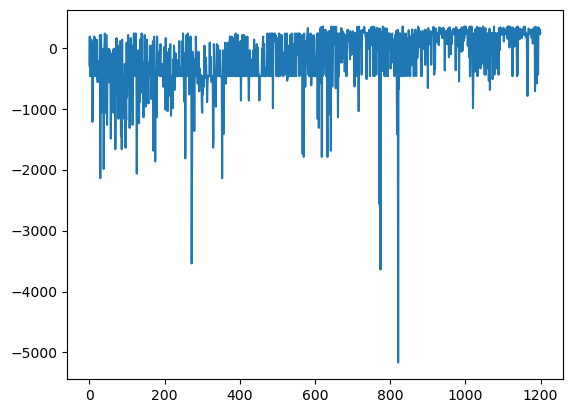

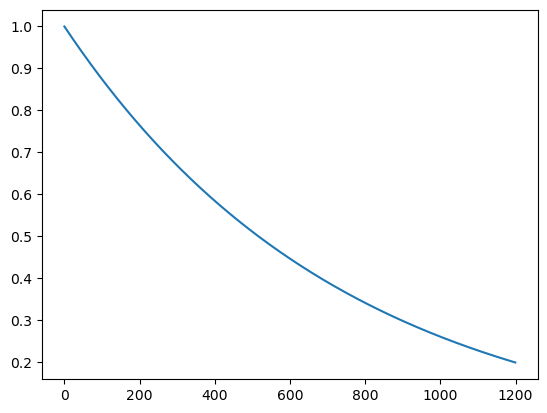

In [55]:
# Hyperparameters
num_of_episodes = 1200
max_steps = 30
learning_rate = 1e-3
min_epsilon = 0.2
epsilon_decay_factor = min_epsilon ** (1 / num_of_episodes)
# epsilon_decay_factor = 0.9999
batch_size = 32
gamma = 0.9
C = 40

# Define the neural network for a 6x6 grayscale image (flattened to 36 pixels)
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Input dimension is 36 because 6x6 = 36 pixels.
        self.fc1 = nn.Linear(36, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 4)  # 4 outputs, one for each action

    def forward(self, x):
        # x is expected to be of shape [batch_size, 6, 6] or [batch_size, 36]
        # Flatten the image if it's not already flat.
        if len(x.shape) > 2:
            x = x.view(x.size(0), -1)  # reshape to [batch_size, 36]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# DQN Agent class
class DQN():
    def __init__(self, env):
        self.env = env
        self.D = deque([], maxlen=1000)  # replay memory
        self.batch_size = batch_size

        self.Q_policy = NeuralNetwork()  # main network
        self.Q_prime = NeuralNetwork()   # target network
        self.Q_prime.load_state_dict(self.Q_policy.state_dict())

        self.init_epsilon = 1.0
        self.rewards = []
        self.epsilon_arr = []
        self.total_steps = 0

        self.criterion = nn.MSELoss()
        self.optimizer = optim.AdamW(self.Q_policy.parameters(), lr=learning_rate)

    def epsilon_greedy(self, prev_state):
        if self.init_epsilon > np.random.random():
            action = self.env.action_space.sample()
        else:
            # prev_state is a 6x6 grayscale image.
            state_tensor = torch.tensor(prev_state, dtype=torch.float32).unsqueeze(0)
            # The forward pass will flatten the image.
            q_values = self.Q_policy(state_tensor)
            action = torch.argmax(q_values).item()
        return action

    def train_model(self):
        if len(self.D) < self.batch_size:
            return

        batch = random.sample(self.D, self.batch_size)

        # Convert batch elements to tensors.
        # Here, s[0] and s[3] are 6x6 images.
        states = torch.tensor([s[0] for s in batch], dtype=torch.float32)
        actions = torch.tensor([s[1] for s in batch], dtype=torch.long).unsqueeze(1)
        rewards = torch.tensor([s[2] for s in batch], dtype=torch.float32)
        next_states = torch.tensor([s[3] for s in batch], dtype=torch.float32)
        dones = torch.tensor([s[4] for s in batch], dtype=torch.float32)

        # Flatten the states to [batch_size, 36] (if not already flattened).
        states = states.view(states.size(0), -1)
        next_states = next_states.view(next_states.size(0), -1)

        # Get the predicted Q-values for the actions taken.
        current_q_values = self.Q_policy(states).gather(1, actions)

        # Compute the target Q-values using the target network.
        next_q_values = self.Q_prime(next_states).max(1)[0]
        target_q_values = rewards + (1 - dones) * gamma * next_q_values
        target_q_values = target_q_values.unsqueeze(1)

        loss = self.criterion(current_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def train(self):
        for episode in range(num_of_episodes):
            prev_state, info = self.env.reset()
            ep_reward = 0

            for t in range(max_steps):
                action = self.epsilon_greedy(prev_state)
                next_state, reward, terminated, truncated, info = self.env.step(action)
                ep_reward += reward

                done = terminated  # or terminated or truncated
                self.D.append((prev_state, action, reward, next_state, done))
                self.train_model()

                prev_state = next_state
                self.total_steps += 1

                if t % C == 0:
                    self.Q_prime.load_state_dict(self.Q_policy.state_dict())

                if done:
                    break

            self.rewards.append(ep_reward)
            self.init_epsilon = max(min_epsilon, self.init_epsilon * epsilon_decay_factor)
            self.epsilon_arr.append(self.init_epsilon)
            print(f"Episode {episode}, Reward: {ep_reward}, Epsilon: {self.init_epsilon}")

        print("Training complete.")
        return self.rewards

# Example usage:
# Assuming you have defined GridEnvironment to return a 6x6 grayscale image as observation.
env = GridEnvironment(max_timesteps=500)
dqn_agent = DQN(env)
training_rewards = dqn_agent.train()

plt.figure(1)
plt.plot(dqn_agent.rewards)
# save_plot_as_img('dqn_warehouse_robot_reward_per_episode.png', dir_to_save_data)

plt.figure(2)
plt.plot(dqn_agent.epsilon_arr)


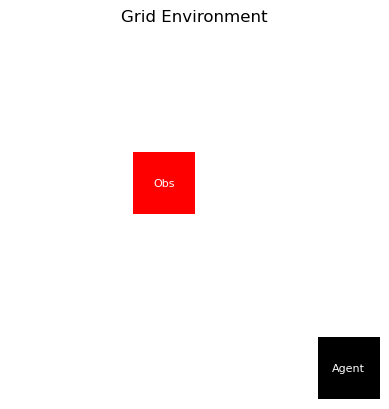

In [60]:
def test(nn, num_episodes=10, max_steps=50):
    from IPython.display import clear_output
    import time
    
    rewards_all_episodes = []
    
    for episode in range(num_episodes):
        obs, info = env.reset()
        
        total_rewards = 0
        
        for step in range(max_steps):
            # Convert observation to a tensor and add batch dimension.
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            # Compute action using the network.
            action = torch.argmax(nn(obs_tensor)).item()
            
            # Execute action.
            obs, reward, terminated, truncated, info = env.step(action)
            total_rewards += reward
            
            # Render the environment.
            env.render()
            time.sleep(.1)  # Pause briefly so updates are visible.
            clear_output(wait=True)  # Clear previous output.
            # print(obs)
            if terminated:
                break
        
        rewards_all_episodes.append(total_rewards)
    
    return rewards_all_episodes

time.sleep(1)
t = test(dqn_agent.Q_policy, num_episodes=1, max_steps=200)
# save_plot_as_img('dqn_warehouse_robot_reward_per_episod_5episodes.png', dir_to_save_data)

In [ ]:

save_path = "dqn_obs_image_3.pth"  # TODO
torch.save(dqn_agent.Q_policy.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to dqn_obs_image_2.pth
